# Imports and Inputs

In [89]:
### Imports of relevant python packages and Dune API Key
import dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
# import seaborn as sns
from datetime import datetime, timedelta, timezone
from dune_client.client import DuneClient
from dune_client.query import QueryBase
from dune_client.types import QueryParameter

# load .env file
dotenv.load_dotenv(".env")
dune = DuneClient.from_env()

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Links to dune queries to refresh before importing latest result in cell below:

[Capital Pool in ETH](https://dune.com/queries/3773645/6345766?display_currency_e15077=ETH)

[RAMM Volumes](https://dune.com/queries/4498759)

[RAMM: BV](https://dune.com/queries/4489888)

[Full List Of Covers V2](https://dune.com/queries/3810247)

[NXM Supply](https://dune.com/queries/4510585)

In [90]:
# import jsons of capital pool, ramm volume and covers from dune api 
#cap_pool_result = dune.get_latest_result_dataframe(3773645) # ensure that the ETH values are latest to be run
#ramm_volume_result = dune.get_latest_result_dataframe(3219988)
#covers_list_result = dune.get_latest_result_dataframe(3810247)

"""  query the query (execute and get latest result) """
cap_pool_query = QueryBase(
    query_id=3773645,
    params=[
      QueryParameter.text_type(name="display_currency", value="ETH"),
    ],
)
cap_pool_result = dune.run_query_dataframe(query=cap_pool_query)

ramm_volume_query = QueryBase(
    query_id=4498759,
    params=[
      QueryParameter.text_type(name="currency", value="ETH"),
    ],
)
ramm_volume_result = dune.run_query_dataframe(query=ramm_volume_query)

ramm_bv_query = QueryBase(
    query_id=4489888,
    params=[
      QueryParameter.text_type(name="currency", value="ETH"),
    ],
)
ramm_bv_result = dune.run_query_dataframe(query=ramm_bv_query)

covers_list_result = dune.run_query_dataframe(QueryBase(query_id=3810247))
nxm_supply_result = dune.run_query_dataframe(QueryBase(query_id=4510585))

2025-04-03 14:45:39,512 INFO dune_client.api.base executing 3773645 on medium cluster
2025-04-03 14:45:39,702 INFO dune_client.api.base waiting for query execution 01JQXYCXH03CGP4EY0WTA8FK03 to complete: ExecutionState.PENDING (queue position: 26)
2025-04-03 14:45:40,756 INFO dune_client.api.base waiting for query execution 01JQXYCXH03CGP4EY0WTA8FK03 to complete: ExecutionState.PENDING (queue position: 25)
2025-04-03 14:45:41,833 INFO dune_client.api.base waiting for query execution 01JQXYCXH03CGP4EY0WTA8FK03 to complete: ExecutionState.PENDING (queue position: 25)
2025-04-03 14:45:42,878 INFO dune_client.api.base waiting for query execution 01JQXYCXH03CGP4EY0WTA8FK03 to complete: ExecutionState.EXECUTING
2025-04-03 14:45:43,923 INFO dune_client.api.base waiting for query execution 01JQXYCXH03CGP4EY0WTA8FK03 to complete: ExecutionState.EXECUTING
2025-04-03 14:45:44,972 INFO dune_client.api.base waiting for query execution 01JQXYCXH03CGP4EY0WTA8FK03 to complete: ExecutionState.EXECUTING

# Investment Newsletter Data

The following steps and the reasons for them were taken for the August metrics:
1. Update the valuation date string (standard each month)

In [91]:
# manually input the valuation date as a string in the format 'dd-mm-yyyy'
# the valuation date is the final day of the month for which the results are being produced
valn_date_str = '31-03-2025'

# average days in month
avg_days_in_month = 30.436875

# create valuation datetime
# valn_date = datetime.strptime(valn_date_str, '%d-%m-%Y').replace(tzinfo=timezone.utc) - timezone UTC if required
valn_date = datetime.strptime(valn_date_str, '%d-%m-%Y')

# create datetime for the final day in month before valuation month

# eom_before_valn_date = datetime(year=valn_date.year, month=valn_date.month, day=1, tzinfo=timezone.utc) - timedelta(days=1) - timezone UTC if required
eom_before_valn_date = datetime(year=valn_date.year, month=valn_date.month, day=1) - timedelta(days=1)

**Kiln reward calculation**

The Kiln rewards are not currently picked up by the Enzyme chainlink oracle and so the metrics are calculated manually in this notebook.

Currently the monthly rewards are estimated by inputting the known unclaimed reward amount as at the date of updating the notebook and assuming that the rewards are evenly spread through the days since the last withdrawal.

Kiln Rewards - [AB Safe Enzyme App](https://app.safe.global/apps/open?safe=eth:0x51ad1265C8702c9e96Ea61Fe4088C2e22eD4418e&appUrl=https%3A%2F%2Fapp.enzyme.finance)

Click Vaults (left sidebar) -> Nexus Mutual Treasury Yield -> 'Portfolio' tab -> Click into Kiln Staking Positions. The relevant value is under 'Total Accrued Rewards'

Steps taken to update notebook:

2. The Enzyme idle portion was removed as funds were allocated between weETH and the Stakewise/Chorus One position. These are captured by the Chainlink oracle so will be automatically allowed for in the Enzyme vault position.
3. The kiln_current_rewards were updated for the Total Accrued Rewards value read from the instructions above.
4. The kiln_first_round rewards represent the amount of rewards earned in the Kiln position before the initial withdrawal of staking rewards between 2024-04-24 and 2024-04-26. This amount, and the kiln_claim_start_date and kiln_claim_end_date will remain unchanged.
5. The kiln_deposit_date represents the first deposit into Kiln and will be unchanged.

In [92]:
# manually input idle Enzyme Portion
Enzyme_idle_portion = 0 # 0.6738 WETH?

# manually input kiln rewards

# fixed amount representing rewards claimed in April '24 and staked afresh in Kiln
kiln_first_round = 181.45

# TO UPDATE - current rewards pulled in from Enzyme UI
kiln_current = 190.881

# FIXED
# create datetime object of 2023/08/30 when the Kiln validators were activated 
# kiln_deposit_date = datetime(year=2023, month=8, day=30, tzinfo=timezone.utc)
kiln_deposit_date = datetime(year=2023, month=8, day=30)
# create datetime objects of 2024/04/24 and 2024/04/26 when the Kiln rewards were first claimed.
    # Note that the values for 2024/04/25 will be inaccurate
# kiln_claim_start_date = datetime(year=2024, month=4, day=24, tzinfo=timezone.utc)
# kiln_claim_end_date = datetime(year=2024, month=4, day=26, tzinfo=timezone.utc)
kiln_claim_start_date = datetime(year=2024, month=4, day=24)
kiln_claim_end_date = datetime(year=2024, month=4, day=26)

kiln_total_rewards = kiln_first_round + kiln_current

**Aave WETH Withdrawal**

The below cell takes in the manual inputs related to any WETH withdrawals in the month, to allow for accurately working out the interest on the collateral.

The relevant values can be found by looking at the historic transactions in the [AB Multisig](https://app.safe.global/transactions/history?safe=eth:0x51ad1265C8702c9e96Ea61Fe4088C2e22eD4418e).

see notes below per Aave USDC Debt Repayments and apply similar approach here


In [93]:
# manually input aEthWETH wihdrawal size and date of wihdrawal

# TO UPDATE from any wihdrawal tx's in month
aEthWETH_monthly_wihdrawal = 0
wihdrawal_date_str = '13-12-2024'

# FIXED
aEthWETH_wihdrawal_date = datetime.strptime(wihdrawal_date_str, '%d-%m-%Y')

**Aave USDC Debt Repayments**

The below cell takes in the manual inputs related to any USDC debt repayments in the month, to allow for accurately working out the interest on the debt.

The relevant values can be found by looking at the historic transactions in the [AB Multisig](https://app.safe.global/transactions/history?safe=eth:0x51ad1265C8702c9e96Ea61Fe4088C2e22eD4418e).
* If there is one payment in the valuation month, simply update the information below.
* If there are no repayments, comment out the section below and update the calculations in section 2.4.
* If there is more than one repayment, then an update to the relevant calculations below and in section 2.4. to include additional payments will be required.

Steps taken to update notebook:

6. Updated the debtUSDC_monthly_repayment as per the relevant August transaction. Note that the USDC amount is used.
7. Updated the repayment_date_str to match the day the repayment was made in August '24

In [94]:
# manually input debtUSDC repayment size and date of repayment

# TO UPDATE from any repayment tx's in month
debtUSDC_monthly_repayment = 419_232.95
repayment_date_str = '12-03-2025'

# FIXED
debtUSDC_repayment_date = datetime.strptime(repayment_date_str, '%d-%m-%Y')

**Staked ETH Sale**

In August, for the first time since making the investment, the mutual converted a significant portion of its stETH back to ETH.

We used the the relevant transactions that track the amount of stETH moving to and back from the `SwapOperator` contract can be found [here](https://etherscan.io/advanced-filter?fadd=0xcafeabed7e0653afe9674a3ad862b78db3f36e60&tadd=0xcafeabed7e0653afe9674a3ad862b78db3f36e60&tkn=0xae7ab96520de3a18e5e111b5eaab095312d7fe84&ps=50)
* Some orders were filled in full, so the entirety of the stETH only went out of the capital pool.
* Some orders were partially filled, so amount of stETH out > amount of stETH back in
* Some orders weren't filled at all, so amount of stETH out = amount of stETH in.
We therefore calculate the amount using a spreadsheet for now but should be able to capture these transactions using Dune Analytics in future.

8. Set the `stETH_sale_amount` to the total stETH sold.
9. Set the `stETH_sale_date_str` to the (last) dat in which the stETH transactions were made.

A harder problem is that the mutual paid trading fees, so didn't quite reach 1-1 stETH->ETH, the typical submitted trade during august was 500 stETH for 499.85 ETH.
The total ETH amount should be available by adding up all the ETH transferred to the capital pool in the relevant "return" transactions, e.g.  https://etherscan.io/tx/0x2f71669241bfb00b9820cb40ea4d8ca6bb4711b600b6c7eedd025b662dd9591c is a partial transaction that includes the number of ETH actually received.

In future occasions where stETH is sold within a month, if we are able to collect the actual amount of ETH obtained by selling the total amount of stETH, we can adjust the stETH return in the month by the trading loss.

In months where there is no stETH sold, set `stETH_sold` below to `0`.

In [95]:
# TO UPDATE for any stETH sale tx's in month with the amount and date of the sale
# limit order set on 31st March and closed on 1st April - partially filled on both days, so will split sale between this and next month newletter
# March = 20.65 + 1580.50
# April = 5097.50
stETH_sale_amount = 20.65 + 1580.50
stETH_sale_date_str = '31-03-2025'

# FIXED
stETH_sale_date = datetime.strptime(stETH_sale_date_str, '%d-%m-%Y')

Commented out the coingecko ETH-USD API as it is not used downstream since updating the Dune queries.

In [96]:
# # coingecko ETH API for ETH-USD at valuation date
# url = 'https://api.coingecko.com/api/v3/coins/ethereum/history'
# eth_price_params_valn = {'date': valn_date_str}
# eth_usd_valn = requests.get(url, params=eth_price_params_valn).json()['market_data']['current_price']['usd']

## Processing Capital Pool Table

In [97]:
cap_pool_result

,block_date,avg_eth_usd_price,capital_pool_display_curr,eth_display_curr,dai_display_curr,nxmty_display_curr,steth_display_curr,reth_display_curr,usdc_display_curr,cbbtc_display_curr,cover_re_usdc_display_curr,aave_collateral_weth_display_curr,aave_debt_usdc_display_curr
0,2025-04-03 00:00:00,1815.549259,69030.650274,11223.848363,285.512346,13487.340318,17284.929015,15132.134956,380.378098,29.213227,6612.285119,6486.585172,-1891.576340
1,2025-04-02 00:00:00,1876.167639,68904.811581,11274.895001,276.274088,13487.340318,17283.512294,15130.987144,368.096763,28.851319,6398.867431,6486.381437,-1830.394215
2,2025-04-01 00:00:00,1876.777083,68979.642502,11354.337010,276.247185,13486.703518,17282.205553,15129.959008,367.973632,28.491541,6397.462028,6486.026425,-1829.763398
3,2025-03-31 00:00:00,1818.095938,67794.902884,4906.684919,285.237032,13486.301986,22378.391917,15128.887420,378.507723,28.837950,6605.376974,6485.669590,-1888.992626
4,2025-03-30 00:00:00,1828.691319,69409.654866,4972.583915,283.758218,13485.799588,23959.824248,15127.825199,373.771384,28.858645,6570.786759,6485.311817,-1878.864907
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,2019-05-27 00:00:00,268.692708,23.625751,23.625751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
2139,2019-05-26 00:00:00,252.561806,23.629793,23.629793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
2140,2019-05-25 00:00:00,251.959896,22.633834,22.633834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
2141,2019-05-24 00:00:00,249.477361,21.537876,21.537876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000


In [98]:
# process capital pool table
df_cap_raw = cap_pool_result

# drop moving average columns
df_cap = df_cap_raw.drop(columns=['capital_pool_display_curr'])
# rename columns
df_cap.rename(columns={
    'eth_display_curr': 'ETH',
    'dai_display_curr': 'DAI',
    'reth_display_curr': 'rETH',
    'steth_display_curr': 'stETH',
    'nxmty_display_curr': 'Enzyme',
    'usdc_display_curr': 'USDC',
    'cbbtc_display_curr': 'cbBTC',
    'cover_re_usdc_display_curr': 'Cover Re',
    'aave_collateral_weth_display_curr': 'aEthWETH',
    'aave_debt_usdc_display_curr': 'variableDebtEthUSDC',
    'avg_eth_usd_price': 'rate_ETH_USD',
    'block_date': 'day'
}, inplace=True)

# change day to a datetime, and remove timezone
df_cap['day'] = pd.to_datetime(df_cap['day']).dt.tz_localize(None)

# Adjust Enzyme for unclaimed Kiln returns
# work out days since kiln deposit from the latest day and work out the rewards per day
days_first_kiln_rewards = (kiln_claim_start_date - kiln_deposit_date)/timedelta(days=1)
daily_first_kiln_rewards = kiln_first_round/days_first_kiln_rewards

days_current_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_claim_end_date)/timedelta(days=1)
daily_current_kiln_rewards = kiln_current/days_current_kiln_rewards

days_total_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_deposit_date)/timedelta(days=1)
daily_total_kiln_rewards = kiln_total_rewards / days_total_kiln_rewards

# create a column for kiln rewards based on the daily values since validators went live
df_cap['kiln_rewards'] = 0.0
df_cap.loc[df_cap['day'] <= kiln_claim_start_date, 'kiln_rewards'] = daily_first_kiln_rewards * ((df_cap['day'] - kiln_deposit_date) / timedelta(days=1))
df_cap.loc[df_cap['day'] >= kiln_claim_end_date, 'kiln_rewards'] = daily_current_kiln_rewards * ((df_cap['day'] - kiln_claim_end_date) / timedelta(days=1))
df_cap.loc[df_cap['kiln_rewards'] < 0, 'kiln_rewards'] = 0

# Add Kiln rewards to Enzyme column and then drop the Kiln rewards column
df_cap['Enzyme'] = df_cap['Enzyme'] + df_cap['kiln_rewards']
df_cap.drop(columns=['kiln_rewards'], inplace=True)

# add all the columns except day and the exchange rate together to get numeric total
df_cap['sum'] = df_cap.drop(columns=['day', 'rate_ETH_USD']).sum(axis=1)

# work out net aave position
df_cap['Aave (net)'] = df_cap['aEthWETH'] + df_cap['variableDebtEthUSDC']

In [99]:
df_cap.loc[(df_cap['day'] <= valn_date) & (df_cap['day'] >= eom_before_valn_date)]

,day,rate_ETH_USD,ETH,DAI,Enzyme,stETH,rETH,USDC,cbBTC,Cover Re,aEthWETH,variableDebtEthUSDC,sum,Aave (net)
3,2025-03-31,1818.095938,4906.684919,285.237032,13675.508591,22378.391917,15128.887420,378.507723,28.837950,6605.376974,6485.669590,-1888.992626,67984.109489,4596.676963
4,2025-03-30,1828.691319,4972.583915,283.758218,13674.448062,23959.824248,15127.825199,373.771384,28.858645,6570.786759,6485.311817,-1878.864907,69598.303340,4606.446910
5,2025-03-29,1861.885694,5071.118152,278.630875,13673.676879,23963.574244,15126.904907,367.004192,28.430603,6452.544766,6484.956690,-1844.814883,69602.026425,4640.141807
6,2025-03-28,1918.492431,5164.062166,270.324836,13672.753762,23961.729079,15125.755006,356.038479,28.252153,6260.415305,6484.608372,-1789.632648,69534.306510,4694.975724
7,2025-03-27,2018.814167,5258.338807,256.820893,13671.786952,23974.096578,15124.595489,338.161509,27.498066,5947.356204,6484.259380,-1699.903462,69383.010416,4784.355917
8,2025-03-26,2042.192118,5354.591334,253.882713,13671.130473,23972.292055,15123.279896,334.246430,27.215703,5879.393407,6483.914739,-1680.257884,69419.688866,4803.656855
9,2025-03-25,2066.725486,5443.242900,250.813337,13670.419166,23970.526748,15122.444869,293.209783,26.890386,5808.363519,6483.562195,-1659.744445,69409.728457,4823.817750
10,2025-03-24,2066.463368,5531.226375,250.877891,13669.261874,23968.751724,15121.327704,292.373711,26.903367,5809.686178,6483.202219,-1659.907448,69493.703593,4823.294770
11,2025-03-23,2005.201632,5661.678371,258.797189,13668.390207,23966.999903,15120.481206,301.333712,26.897184,5992.925441,6482.839986,-1712.040580,69768.302618,4770.799406
12,2025-03-22,1990.802014,5761.957844,260.535510,13667.243185,23965.251681,15119.365654,303.299047,26.926527,6034.571955,6482.481263,-1723.705819,69897.926847,4758.775444


## Pie Chart of Assets at Valuation Date

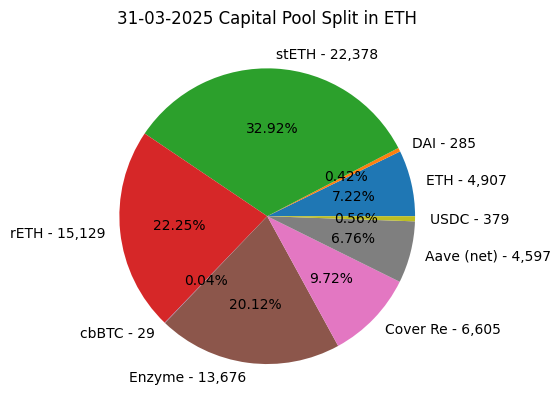

In [100]:
# pie chart of assets
asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'cbBTC', 'Enzyme', 'Cover Re', 'Aave (net)', 'USDC']
valn_date_row = df_cap.loc[df_cap['day'] == valn_date][asset_list]

# add formatted ETH values to labels
labels = []
for n, i in enumerate(asset_list):
    formatted_value = '{:,.0f}'.format(valn_date_row.values[0][n])
    labels.append(f'{i} - {formatted_value}')

# create chart
plt.pie(valn_date_row.values[0], labels=labels, autopct='%1.2f%%')
plt.title(f'{valn_date_str} Capital Pool Split in ETH');

## Monthly Changes in Capital Pool

### RAMM Volumes & BV

In [101]:
# RAMM Net Withdrawals
df_ramm = ramm_volume_result

# change timestamp to datetime format and normalise all dates to midnight
#df_ramm['block_date'] = pd.to_datetime(df_ramm['block_date']).dt.floor('D')
df_ramm['block_date'] = pd.to_datetime(df_ramm['block_date']).dt.tz_localize(None).dt.floor('D')

# group by date, take the latest value and re-sort into descending order
# not necessary any more - new query groups by date already
#df_ramm = df_ramm.groupby(by=df_ramm['block_date'].dt.date, as_index=False).first().sort_values(['block_date'], ascending=False).reset_index(drop=True)

# convert columns to numeric (errors='coerce' will replace non-convertible values with NaN)
df_ramm['cummulative_eth_in'] = pd.to_numeric(df_ramm['cummulative_eth_in'], errors='coerce')
df_ramm['cummulative_eth_out'] = pd.to_numeric(df_ramm['cummulative_eth_out'], errors='coerce')
df_ramm['cummulative_nxm_in'] = pd.to_numeric(df_ramm['cummulative_nxm_in'], errors='coerce')
df_ramm['cummulative_nxm_out'] = pd.to_numeric(df_ramm['cummulative_nxm_out'], errors='coerce')

# determine net ramm flows 30 days before and on the valuation date by subtracting redemptions from mints
# ensure no NaN values in the relevant rows for the calculation
if not df_ramm.loc[df_ramm['block_date'] == eom_before_valn_date][['cummulative_eth_in', 'cummulative_eth_out', 'cummulative_nxm_in', 'cummulative_nxm_out']].isna().any().any():
    ramm_flows_monthly_opening = (
        df_ramm.loc[df_ramm['block_date'] == eom_before_valn_date]['cummulative_eth_in'].values[0] -
        df_ramm.loc[df_ramm['block_date'] == eom_before_valn_date]['cummulative_eth_out'].values[0]
    )
    ramm_flows_monthly_closing = (
        df_ramm.loc[df_ramm['block_date'] == valn_date]['cummulative_eth_in'].values[0] - 
        df_ramm.loc[df_ramm['block_date'] == valn_date]['cummulative_eth_out'].values[0]
    )
    ramm_flows_monthly_nxm_opening = (
        df_ramm.loc[df_ramm['block_date'] == eom_before_valn_date]['cummulative_nxm_in'].values[0] -
        df_ramm.loc[df_ramm['block_date'] == eom_before_valn_date]['cummulative_nxm_out'].values[0]
    )
    ramm_flows_monthly_nxm_closing = (
        df_ramm.loc[df_ramm['block_date'] == valn_date]['cummulative_nxm_in'].values[0] - 
        df_ramm.loc[df_ramm['block_date'] == valn_date]['cummulative_nxm_out'].values[0]
    )
else:
    print("Missing or invalid data in 'cummulative_eth_in' or 'cummulative_eth_out' /  'cummulative_nxm_in' or 'cummulative_nxm_out'")

# determine net flows from ramm in 30 days before valuation date 
ramm_flow_monthly_eth_change = ramm_flows_monthly_closing - ramm_flows_monthly_opening
ramm_flow_monthly_nxm_change = ramm_flows_monthly_nxm_closing - ramm_flows_monthly_nxm_opening
print(f'RAMM monthly change (ETH) = {ramm_flow_monthly_eth_change}')
print(f'RAMM monthly change (NXM) = {ramm_flow_monthly_nxm_change}')

# RAMM BV processing
df_ramm_bv = ramm_bv_result
df_ramm_bv['block_minute'] = pd.to_datetime(df_ramm_bv['block_minute'])

ramm_bv_monthly_opening = df_ramm_bv.loc[
  df_ramm_bv['block_minute'].dt.date == eom_before_valn_date.date(),
  'bv_diff_cummulative'
].iloc[0]

ramm_bv_monthly_closing = df_ramm_bv.loc[
    df_ramm_bv['block_minute'].dt.date == valn_date.date(), 
    'bv_diff_cummulative'
].iloc[0]

ramm_bv_monthly_eth_change = ramm_bv_monthly_closing - ramm_bv_monthly_opening
print(f'RAMM monthly BV (ETH) = {ramm_bv_monthly_eth_change}')


RAMM monthly change (ETH) = -3105.8135219870164
RAMM monthly change (NXM) = 141654.33429976692
RAMM monthly BV (ETH) = 287.42180718405234


### Cover Fees

In [102]:
df_covers = covers_list_result

# input commission ratio to obtain cover fees net of commission (representing inflows to Cap Pool)
net_of_commission_ratio = 0.85

# obtain closing ETH/USD price
eth_usd_closing = df_cap.loc[df_cap['day'] == valn_date]['rate_ETH_USD'].values[0]

# change timestamp to datetime format and normalise all dates to midnight
df_covers['cover_start_time'] = pd.to_datetime(df_covers['cover_start_time']).dt.floor('D').dt.tz_localize(None)

# filter for covers that were bought the month of the valn date
df_covers_valn_month = df_covers[(df_covers['cover_start_time'] > eom_before_valn_date) & (df_covers['cover_start_time']<=valn_date)]

# filter for covers that were paid for in ETH
df_covers_valn_month_eth = df_covers_valn_month[df_covers_valn_month['premium_asset'] == 'ETH']
# work out cover fees denominated in ETH, allowing for 15% commission
monthly_cover_fees_eth = df_covers_valn_month_eth['premium_native'].sum() * net_of_commission_ratio
print(f'ETH Cover Fees = {monthly_cover_fees_eth}')

# filter for covers that were paid for in DAI
df_covers_valn_month_dai = df_covers_valn_month[df_covers_valn_month['premium_asset'] == 'DAI']
# work out cover fees denominated in ETH, allowing for 15% commission
monthly_cover_fees_dai = df_covers_valn_month_dai['premium_native'].sum() * net_of_commission_ratio
monthly_cover_fees_dai_in_eth = monthly_cover_fees_dai / eth_usd_closing
print(f'DAI Cover Fees = {monthly_cover_fees_dai_in_eth}')

# filter for covers that were paid for in USDC
df_covers_valn_month_usdc = df_covers_valn_month[df_covers_valn_month['premium_asset'] == 'USDC']
# work out cover fees denominated in ETH, allowing for 15% commission
monthly_cover_fees_usdc = df_covers_valn_month_usdc['premium_native'].sum() * net_of_commission_ratio
monthly_cover_fees_usdc_in_eth = monthly_cover_fees_usdc / eth_usd_closing
print(f'USDC Cover Fees = {monthly_cover_fees_usdc_in_eth}')

monthly_cover_fees = monthly_cover_fees_eth + monthly_cover_fees_dai_in_eth + monthly_cover_fees_usdc_in_eth
print(f'Total Cover Fees = {monthly_cover_fees}')

# find total of monthly cover fees in NXM
monthly_cover_fees_nxm = df_covers_valn_month['premium_nxm'].sum() * net_of_commission_ratio
print(f'Total Cover Fees (NXM) = {monthly_cover_fees_nxm}')

ETH Cover Fees = 43.549492553878174
DAI Cover Fees = 0.0
USDC Cover Fees = 170.66989668870258
Total Cover Fees = 214.21938924258075
Total Cover Fees (NXM) = 8773.359428960102


### FX Impacts

In [103]:
# exchange rate changes
eth_usd_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['rate_ETH_USD'].values[0]

# get net monthly change from opening DAI
dai_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['DAI'].values[0]

# dai_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['DAI'].values[0]
# dai_monthly_closing_less_fees = dai_monthly_closing - monthly_cover_fees_dai_in_eth

# # allow for withdrawals
# dai_withdrawals_eth = dai_cover_re_withdrawals / eth_usd_opening

# dai_change = dai_monthly_opening - dai_withdrawals_eth - dai_monthly_closing_less_fees
dai_fx_change = dai_monthly_opening * eth_usd_opening / eth_usd_closing - dai_monthly_opening

In [104]:
# USDC FX Impact
usdc_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['USDC'].values[0]

usdc_fx_change = usdc_monthly_opening * eth_usd_opening / eth_usd_closing - usdc_monthly_opening

In [105]:
# Cover Re FX impact
cover_re_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['Cover Re'].values[0]

cover_re_fx_change = cover_re_opening * eth_usd_opening / eth_usd_closing - cover_re_opening

In [106]:
# debtUSDC FX impact
debtUSDC_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['variableDebtEthUSDC'].values[0]

# FX Impact
debtUSDC_fx_change = debtUSDC_opening * eth_usd_opening / eth_usd_closing - debtUSDC_opening

In [107]:
# Total FX Impacts
fx_change = dai_fx_change + usdc_fx_change + cover_re_fx_change + debtUSDC_fx_change

In [108]:
print(f'opening date: {eom_before_valn_date}, closing date: {valn_date}')
print(f'ETH/USD opening = {eth_usd_opening}')
print(f'ETH/USD closing = {eth_usd_closing}')

print(f'DAI FX Impact = {dai_fx_change}')
print(f'USDC FX Impact = {usdc_fx_change}')
print(f'Cover Re FX Impact = {cover_re_fx_change}')
print(f'debtUSDC FX Impact = {debtUSDC_fx_change}')

print(f'Total FX Impact = {fx_change}')

opening date: 2025-02-28 00:00:00, closing date: 2025-03-31 00:00:00
ETH/USD opening = 2179.961736111109
ETH/USD closing = 1818.095937500001
DAI FX Impact = 47.3337886755109
USDC FX Impact = 70.43359440240613
Cover Re FX Impact = 1096.3349134206119
debtUSDC FX Impact = -350.3430996690447
Total FX Impact = 863.7591968294842


#### TEMPORARY For New Investment in May - FX Impacts Allowing for Cover Re investment

In future treat Cover Re, Aave Debt, USDC and DAI as per above.

In [109]:
# cover_re_date_str = '23-05-2024'
# cover_re_date = datetime.strptime(cover_re_date_str, '%d-%m-%Y')
# eth_usd_cover_re_date = df_cap.loc[df_cap['day'] == cover_re_date]['rate_ETH_USD'].values[0]

In [110]:
# # USDC Split into before and after Cover Re
# usdc_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['USDC'].values[0]
# usdc_cover_re_opening = df_cap.loc[df_cap['day'] == cover_re_date]['USDC'].values[0]
# # Before Cover Re
# usdc_fx_change_pre_cover_re = usdc_monthly_opening * eth_usd_opening / eth_usd_cover_re_date - usdc_monthly_opening
# print(f'USDC FX Impact Pre Cover Re = {usdc_fx_change_pre_cover_re}')
# # After Cover Re
# usdc_fx_change_post_cover_re = usdc_cover_re_opening * eth_usd_cover_re_date / eth_usd_closing - usdc_cover_re_opening
# print(f'USDC FX Impact Post Cover Re = {usdc_fx_change_post_cover_re}')

In [111]:
# # DAI Split into before and after Cover Re
# dai_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['DAI'].values[0]
# dai_cover_re_opening = df_cap.loc[df_cap['day'] == cover_re_date]['DAI'].values[0]
# # Before Cover Re
# dai_fx_change_pre_cover_re = dai_monthly_opening * eth_usd_opening / eth_usd_cover_re_date - dai_monthly_opening
# print(f'DAI FX Impact Pre Cover Re = {dai_fx_change_pre_cover_re}')
# # After Cover Re
# dai_fx_change_post_cover_re = dai_cover_re_opening * eth_usd_cover_re_date / eth_usd_closing - dai_cover_re_opening
# print(f'DAI FX Impact Post Cover Re = {dai_fx_change_post_cover_re}')

In [112]:
# # debtUSDC FX impact
# debtUSDC_opening = df_cap.loc[df_cap['day'] == cover_re_date]['variableDebtEthUSDC'].values[0]

# # FX Impact
# debtUSDC_fx_change = debtUSDC_opening * eth_usd_cover_re_date / eth_usd_closing - debtUSDC_opening
# print(f'debtUSDC FX Impact = {debtUSDC_fx_change}')

## Monthly Returns on Investments

In [113]:
# Full Monthly Returns

# ETH denominated monthly returns on individual investments

# stETH metrics in ETH
# stETH monthly opening value adjusted for any sales made in month
stETH_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['stETH'].values[0] - stETH_sale_amount
stETH_closing = df_cap.loc[df_cap['day'] == valn_date]['stETH'].values[0]
stETH_monthly_return = stETH_closing - stETH_monthly_opening
# derivation of stETH APY denominator based on timing of sale
stETH_before = df_cap.loc[df_cap['day'] == eom_before_valn_date]['stETH'].values[0]
stETH_after = df_cap.loc[df_cap['day'] == stETH_sale_date + timedelta(days=1)]['stETH'].values[0]
days_before = (stETH_sale_date - eom_before_valn_date)/timedelta(days=1)
days_after = (valn_date - stETH_sale_date)/timedelta(days=1)
stETH_base = (stETH_before * days_before + stETH_after * days_after) / (days_before + days_after)
# stETH monthly percentage return
stETH_monthly_percentage = stETH_monthly_return / stETH_base
# stETH annualised return last month
stETH_monthly_APY = (1 + stETH_monthly_percentage) ** 12 - 1
print(f'stETH Monthly APY: {round(stETH_monthly_APY * 100, 3)}%')
print(f'stETH Monthly Return: {round(stETH_monthly_return, 3)}')

# rETH metrics in ETH
rETH_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['rETH'].values[0]
rETH_closing = df_cap.loc[df_cap['day'] == valn_date]['rETH'].values[0]
rETH_monthly_return = rETH_closing - rETH_monthly_opening
# rETH monthly percentage
rETH_monthly_percentage = rETH_monthly_return / rETH_monthly_opening
# rETH annualised return last month
rETH_monthly_APY = (1 + rETH_monthly_percentage) ** 12 - 1
print(f'rETH Monthly APY: {round(rETH_monthly_APY * 100, 3)}%')
print(f'rETH Monthly Return: {round(rETH_monthly_return, 3)}')

## Enzyme
Enzyme_fee = 0.0015
# Enzyme overall metrics in ETH
Enzyme_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['Enzyme'].values[0]
Enzyme_closing = df_cap.loc[df_cap['day'] == valn_date]['Enzyme'].values[0]
Enzyme_monthly_return = Enzyme_closing - Enzyme_monthly_opening 
# Enzyme monthly percentage
Enzyme_monthly_percentage = Enzyme_monthly_return / Enzyme_monthly_opening
# Enzyme annualised return last month
Enzyme_monthly_APY = (1 + Enzyme_monthly_percentage) ** 12 - 1
Enzyme_monthly_APY_after_fees = Enzyme_monthly_APY - Enzyme_fee
    
# # Kiln standalone metrics in ETH
# Kiln_monthly_opening = Enzyme_monthly_opening - Enzyme_idle_portion
# Kiln_closing = Enzyme_closing - Enzyme_idle_portion
# Kiln_monthly_return = Kiln_closing - Kiln_monthly_opening
# # Kiln monthly percentage
# Kiln_monthly_percentage = Kiln_monthly_return / Kiln_monthly_opening
# # Kiln annualised return last month
# Kiln_monthly_APY = (1 + Kiln_monthly_percentage) ** 12 - 1
# Kiln_monthly_APY_after_fees = Kiln_monthly_APY - Enzyme_fee

print(f'Enzyme Vault Monthly APY: {round(Enzyme_monthly_APY_after_fees * 100, 3)}%')
print(f'Enzyme Vault Return: {round(Enzyme_monthly_return, 3)}')

# aEthWETH metrics in ETH
aEthWETH_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['aEthWETH'].values[0]
aEthWETH_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['aEthWETH'].values[0]
# allowing for aEthWETH withdrawal
aEthWETH_monthly_return = aEthWETH_monthly_wihdrawal + aEthWETH_monthly_closing - aEthWETH_monthly_opening
# aEthWETH monthly percentage
aEthWETH_monthly_percentage = aEthWETH_monthly_return / aEthWETH_monthly_opening
# aEthWETH annualised return last month
aEthWETH_monthly_APY = (1 + aEthWETH_monthly_percentage) ** 12 - 1
print(f'aEthWETH APY: {round(aEthWETH_monthly_APY * 100, 3)}%')
print(f'aEthWETH Return: {round(aEthWETH_monthly_return, 3)}')

# debtUSDC metrics in ETH
debtUSDC_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['variableDebtEthUSDC'].values[0]
debtUSDC_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['variableDebtEthUSDC'].values[0]
# allowing for debtUSDC repayment
# Read ETH-USD value as at repayment date
eth_usd_repayment = df_cap.loc[df_cap['day'] == debtUSDC_repayment_date]['rate_ETH_USD'].values[0]
# Value of repayment in ETH
debtUSDC_monthly_repayment_eth = debtUSDC_monthly_repayment / eth_usd_repayment
# debtUSDC_monthly_return
debtUSDC_monthly_return = debtUSDC_monthly_closing - (debtUSDC_monthly_opening + debtUSDC_fx_change + debtUSDC_monthly_repayment_eth)
# debtUSDC monthly percentage
# Note: not fully accurate, as we compare it to the opening value, not the time-weighted average balance through the month
debtUSDC_monthly_percentage = debtUSDC_monthly_return / debtUSDC_monthly_opening
# debtUSDC annualised return last month
debtUSDC_monthly_APY = (1 + debtUSDC_monthly_percentage) ** 12 - 1
print(f'debtUSDC APY: {round(debtUSDC_monthly_APY * 100, 3)}%')
print(f'debtUSDC Return: {round(debtUSDC_monthly_return, 3)}')

# Aave Net
aave_net_monthly_return = aEthWETH_monthly_return + debtUSDC_monthly_return

# Aave net monthly percentage
aave_net_monthly_percentage = aave_net_monthly_return / aEthWETH_monthly_opening
# Aave net annualised return last month
aave_net_monthly_APY = (1 + aave_net_monthly_percentage) ** 12 - 1
print(f'Aave Net APY: {round(aave_net_monthly_APY * 100, 3)}%')
print(f'Aave Net Return: {round(aave_net_monthly_return, 3)}')

stETH Monthly APY: 2.947%
stETH Monthly Return: 57.968
rETH Monthly APY: 2.841%
rETH Monthly Return: 35.282
Enzyme Vault Monthly APY: 2.655%
Enzyme Vault Return: 31.486
aEthWETH APY: 2.163%
aEthWETH Return: 11.555
debtUSDC APY: -0.135%
debtUSDC Return: 0.198
Aave Net APY: 2.2%
Aave Net Return: 11.753


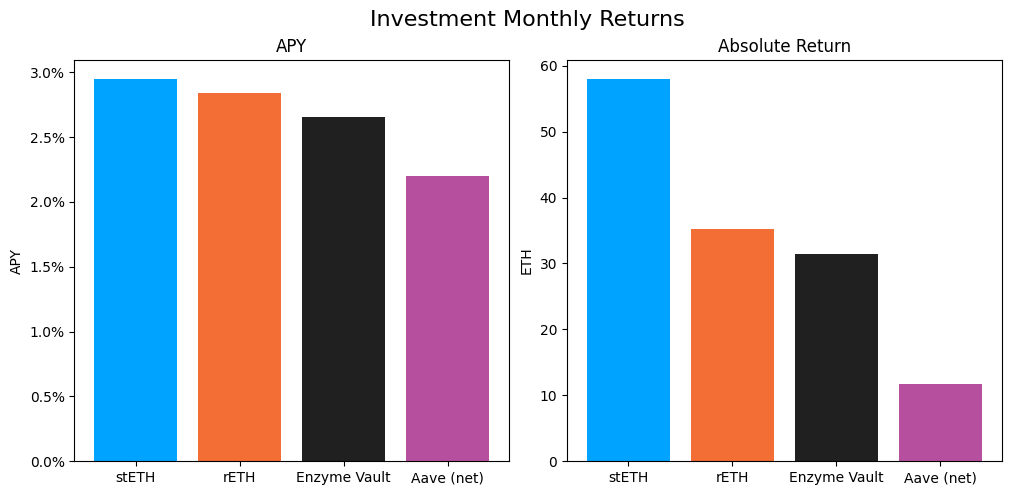

In [114]:
# MONTHLY RETURN GRAPHS FOR INDIVIDUAL INVESTMENTS
labels = ['stETH', 'rETH', 'Enzyme Vault', 'Aave (net)']
colors = ['#00a3ff', '#f26e34', '#202020', '#b6509e']

# Destructuring initialization
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Investment Monthly Returns', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Subplot 1 - APY
axs[0].bar(labels, [stETH_monthly_APY, rETH_monthly_APY, Enzyme_monthly_APY_after_fees, aave_net_monthly_APY], color=colors)
axs[0].set_title('APY')
axs[0].set_ylabel('APY')

# Fix y-ticks for APY subplot
tick_vals_apy = axs[0].get_yticks()
axs[0].yaxis.set_major_locator(FixedLocator(tick_vals_apy))
axs[0].set_yticklabels(['{:,.1%}'.format(x) for x in tick_vals_apy])

# Subplot 2 - Absolute Return
axs[1].bar(labels, [stETH_monthly_return, rETH_monthly_return, Enzyme_monthly_return * (1 - 0.0015), aave_net_monthly_return], color=colors)
axs[1].set_title('Absolute Return')
axs[1].set_ylabel('ETH')

plt.show()

In [115]:
# Total Monthly APY on the Capital Pool

# Total ETH earned
total_monthly_inv_earnings = round(stETH_monthly_return + rETH_monthly_return + Enzyme_monthly_return*(1-0.0015) + aave_net_monthly_return, 3)

# averaging the total ETH value of capital pool over the monthly period
total_cap_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['sum'].values[0]
total_cap_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['sum'].values[0]
avg_total_cap_pool = (total_cap_monthly_closing + total_cap_monthly_opening) / 2

# monthly apy based on total earning
total_monthly_percentage = total_monthly_inv_earnings / avg_total_cap_pool
total_monthly_APY = ((1 + total_monthly_percentage) ** 12 - 1)

print(f'Total Monthly APY: {round(total_monthly_APY * 100, 3)}%')
print('Based on average Capital Pool amount over the monthly period')
print(f'Total ETH Earned: {total_monthly_inv_earnings}')

Total Monthly APY: 2.374%
Based on average Capital Pool amount over the monthly period
Total ETH Earned: 136.441


In [116]:
# Printout

print(f'stETH Monthly Return: {round(stETH_monthly_return, 3)}')
print(f'stETH Monthly APY: {round(stETH_monthly_APY * 100, 3)}%\n')
print(f'rETH Monthly Return: {round(rETH_monthly_return, 3)}')
print(f'rETH Monthly APY: {round(rETH_monthly_APY * 100, 3)}%\n')
print(f'Enzyme Vault Monthly Return: {round(Enzyme_monthly_return * (1-0.0015), 3)}')
print(f'Enzyme Vault Monthly APY: {round(Enzyme_monthly_APY_after_fees * 100, 3)}%')
print(f'Enzyme Vault includes Kiln, EtherFi and Chorus One/Stakewise V3 investments\n')
print(f'aEthWETH Return: {round(aEthWETH_monthly_return, 3)}')
print(f'aEthWETH APY: {round(aEthWETH_monthly_APY * 100, 3)}%')
print(f'debtUSDC Return: {round(debtUSDC_monthly_return, 3)}')
print(f'debtUSDC APY: {round(debtUSDC_monthly_APY * 100, 3)}%')
print(f'Aave Net Return: {round(aave_net_monthly_return, 3)}')
print(f'Aave Net APY: {round(aave_net_monthly_APY * 100, 3)}%\n')
print(f'Total ETH Earned: {total_monthly_inv_earnings}')
print(f'Total Monthly APY: {round(total_monthly_APY * 100, 3)}%')
print('Based on average Capital Pool amount over the monthly period\n')

print ('All returns after fees')

stETH Monthly Return: 57.968
stETH Monthly APY: 2.947%

rETH Monthly Return: 35.282
rETH Monthly APY: 2.841%

Enzyme Vault Monthly Return: 31.439
Enzyme Vault Monthly APY: 2.655%
Enzyme Vault includes Kiln, EtherFi and Chorus One/Stakewise V3 investments

aEthWETH Return: 11.555
aEthWETH APY: 2.163%
debtUSDC Return: 0.198
debtUSDC APY: -0.135%
Aave Net Return: 11.753
Aave Net APY: 2.2%

Total ETH Earned: 136.441
Total Monthly APY: 2.374%
Based on average Capital Pool amount over the monthly period

All returns after fees


## Monthly Changes in Capital Pool 

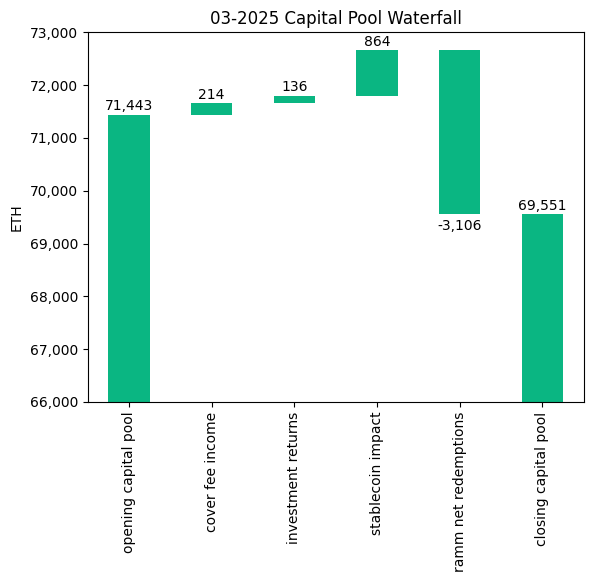

In [139]:
# waterfall chart for changes in the capital pool

# UPDATE
# set limits on chart manually
bottom = 66_000
top = 73_000

# create dataframe with relevant categories
index = ['opening capital pool', 'cover fee income', 'investment returns', 'stablecoin impact', 'ramm net redemptions']
data = {'amount': [total_cap_monthly_opening, monthly_cover_fees, total_monthly_inv_earnings, fx_change, ramm_flow_monthly_eth_change]}
df_waterfall = pd.DataFrame(data=data, index=index)

# create a shifted dataframe by one space and fill the empty space with zero
df_shift = df_waterfall.amount.cumsum().shift(1).fillna(0)

# add the 'closing' line to both dataframes
total_eth = df_waterfall.sum().amount
df_waterfall.loc['closing capital pool'] = total_eth
df_shift.loc['closing capital pool'] = 0

# define the Nexus Mutual green color
color = '#0AB682'

# create waterfall plot
waterfall_plot = df_waterfall.plot.bar(
    stacked=True, bottom=df_shift, legend=None, color=color,
    title=f'{valn_date_str[-7:]} Capital Pool Waterfall'
)
waterfall_plot.set_ylim(bottom=bottom, top=top)
waterfall_plot.set_ylabel('ETH')

# change format of tick values
tick_vals = waterfall_plot.get_yticks()
waterfall_plot.set_yticks(tick_vals)
waterfall_plot.set_yticklabels([f'{x:,.0f}' for x in tick_vals])

# label loop for individual items
maximum = df_waterfall['amount'].max()
neg_offset = maximum / 250
pos_offset = maximum / 800

y_height = df_shift

for loop, (index, row) in enumerate(df_waterfall.iterrows()):
    y = y_height.iloc[loop] + row['amount']
    # determine negative or positive offset
    if row['amount'] > 0:
        y += pos_offset
    else:
        y -= neg_offset
    waterfall_plot.annotate(f"{row['amount']:,.0f}", (loop, y), ha="center")
    

In [118]:
# NXM supply
df_nxm_supply = nxm_supply_result
# change day to a datetime, and remove timezone
df_nxm_supply['block_date'] = pd.to_datetime(df_nxm_supply['block_date']).dt.tz_localize(None)
nxm_supply_monthly_opening = df_nxm_supply.loc[df_nxm_supply['block_date'] == eom_before_valn_date]['total_nxm'].values[0]
nxm_supply_monthly_closing = df_nxm_supply.loc[df_nxm_supply['block_date'] == valn_date]['total_nxm'].values[0]
nxm_supply_monthly_change = abs(nxm_supply_monthly_closing - nxm_supply_monthly_opening)
print(f'NXM supply opening = {nxm_supply_monthly_opening:,.4f}')
print(f'NXM supply closing = {nxm_supply_monthly_closing:,.4f}')
print(f'NXM supply change = {nxm_supply_monthly_change:,.4f}')

NXM supply opening = 2,999,004.6561
NXM supply closing = 2,862,024.9803
NXM supply change = 136,979.6758


### Changes in the capital pool as a book value per NXM value

1. Opening Book Value per NXM = Opening Capital Pool / NXM at start of month
2. Cover Fees and Claims = ETH from Cover Fees and Claims / (Opening NXM + NXM mints from Cover Fees - NXM Burns from Claims) / 2
   note: BV impact is divided by 2 due to minting/burning mechanism at 50% of cover fees/claims
3. Inv Returns = Investment Return / NXM from #2
4. Stable Coin Impact = Stable Coin Impact / NXM from #2
5. Value Add from RAMM = Value Added from RAMM during month / NXM from #2
6. Closing Book Value per NXM

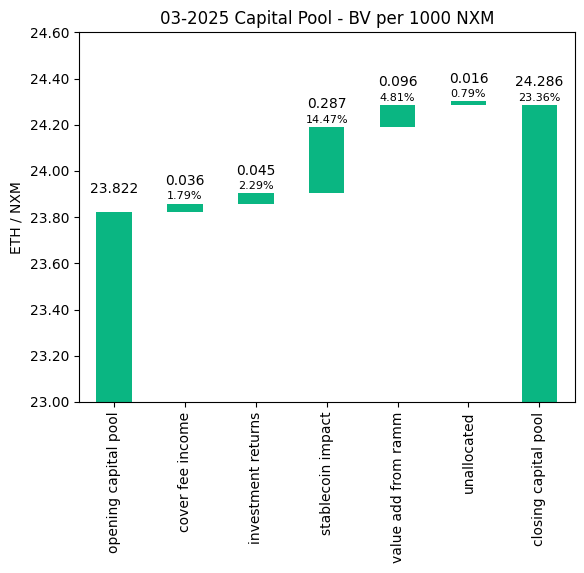

In [144]:
# waterfall chart for changes in the capital pool as a book value per NXM value

# UPDATE
# set limits on chart manually
bottom = 23.00
top = 24.50
factor = 1000

# calc prep following steps described in "Changes in the capital pool as a book value per NXM value"
nxm_monthly_total = nxm_supply_monthly_opening + monthly_cover_fees_nxm # todo: + NXM claims burn (n/a this month)
cap_pool_change_total = total_cap_monthly_opening / nxm_supply_monthly_opening + (monthly_cover_fees + total_monthly_inv_earnings + fx_change) / nxm_monthly_total
#ramm_monthly_change_total = ((cap_pool_change_total - ramm_flow_monthly_eth_change) / (nxm_monthly_total - ramm_flow_monthly_nxm_change)) - cap_pool_change_total / nxm_monthly_total

# create dataframe with relevant categories
index = ['opening capital pool', 'cover fee income', 'investment returns', 'stablecoin impact', 'value add from ramm']
data = {
    'amount': [
        total_cap_monthly_opening / nxm_supply_monthly_opening * factor, 
        monthly_cover_fees / nxm_monthly_total / 2 * factor, 
        total_monthly_inv_earnings / nxm_monthly_total * factor, 
        fx_change / nxm_monthly_total * factor, 
        ramm_bv_monthly_eth_change / nxm_monthly_total * factor
    ]
}
df_waterfall_nxm = pd.DataFrame(data=data, index=index)

# add the 'closing' line to both dataframes
total_nxm = df_waterfall_nxm.sum().amount
closing_nxm = total_eth / nxm_supply_monthly_closing * factor # based on: Ending Capital Pool / Ending NXM
total_diff = closing_nxm - total_nxm
df_waterfall_nxm.loc['unallocated'] = total_diff

# create a shifted dataframe by one space and fill the empty space with zero
df_shift_nxm = df_waterfall_nxm.amount.cumsum().shift(1).fillna(0)

df_waterfall_nxm.loc['closing capital pool'] = total_nxm
df_shift_nxm.loc['closing capital pool'] = 0

# define the Nexus Mutual green color
color = '#0AB682'

# create waterfall plot
waterfall_plot_nxm = df_waterfall_nxm['amount'].plot(
    kind='bar', stacked=True, bottom=df_shift_nxm, legend=None, color=color,
    title=f'{valn_date_str[-7:]} Capital Pool - BV per 1000 NXM'
)
waterfall_plot_nxm.set_ylim(bottom=bottom, top=top)
waterfall_plot_nxm.set_ylabel('ETH / NXM')

# change format of tick values
tick_vals = waterfall_plot_nxm.get_yticks()
waterfall_plot_nxm.set_yticks(tick_vals)
waterfall_plot_nxm.set_yticklabels([f'{x:.2f}' for x in tick_vals])

# label loop for individual items
maximum = df_waterfall_nxm['amount'].max()
neg_offset = maximum / 20
pos_offset = maximum / 300

y_height = df_shift_nxm

"""
for loop, (index, row) in enumerate(df_waterfall_nxm.iterrows()):
    y = y_height.iloc[loop] + row['amount']
    # determine negative or positive offset
    if row['amount'] > 0:
        y += pos_offset
    else:
        y -= neg_offset
    waterfall_plot_nxm.annotate(f"{row['amount']:.3f}", (loop, y), ha="center")
"""

opening_value = df_waterfall_nxm.loc['opening capital pool', 'amount']

for i, (label, row) in enumerate(df_waterfall_nxm.iterrows()):
    bar_value = row['amount']
    cumulative = df_shift_nxm.iloc[i] + bar_value
    
    if bar_value > 0:
        y_main = cumulative + pos_offset
        y_yield = y_main - pos_offset / 1.3  # increased gap between lines
    else:
        y_main = cumulative - neg_offset
        y_yield = y_main - neg_offset  # increased gap between lines
    
    waterfall_plot_nxm.annotate(f"{bar_value:.3f}", (i, y_main), ha="center")
    
    if label == 'opening capital pool':
        continue
    if label == 'closing capital pool':
        yield_val = ((bar_value / opening_value) - 1) * 12 * 100
    else:
        yield_val = (bar_value / opening_value) * 12 * 100
    
    waterfall_plot_nxm.annotate(f"{yield_val:.2f}%", (i, y_yield), ha="center", fontsize=8)


In [120]:
df_waterfall

,amount
opening capital pool,71442.855335
cover fee income,214.219389
investment returns,136.441000
stablecoin impact,863.759197
ramm net redemptions,-3105.813522
closing capital pool,69551.461399


In [121]:
df_waterfall_nxm

,amount
opening capital pool,23.822189
cover fee income,0.035611
investment returns,0.045363
stablecoin impact,0.287175
value add from ramm,0.095560
unallocated,0.015589
closing capital pool,24.285897


In [122]:
# calc steps

print('1. Opening Book Value per NXM = Opening Capital Pool / NXM at start of month')
print(
  f'   Opening Capital Pool = {total_cap_monthly_opening:,.6f}, ',
  f'NXM at start of month = {nxm_supply_monthly_opening:,.6f} -> ',
  f'Opening Book Value per NXM = {total_cap_monthly_opening / nxm_supply_monthly_opening:,.6f}'
)
print()

print('2. Cover Fees and Claims = ETH from Cover Fees and Claims / (Opening NXM + NXM mints from Cover Fees - NXM Burns from Claims) / 2')
print(
  f'   Cover Fees - Claims = {monthly_cover_fees:,.6f}, ',
  f'(NXM at start of month + NXM minted for cover fees - NXM burned for claims) = {nxm_monthly_total:,.6f} -> ',
  f'Change due to Cover Fees and Claims = {monthly_cover_fees / nxm_monthly_total:,.6f}'
)
print()

print('3. Inv Returns = Investment Return / NXM from #2')
print(
  f'   Investment Return = {total_monthly_inv_earnings:,.6f} -> Change due to Inv Returns = {total_monthly_inv_earnings / nxm_monthly_total:,.6f}'
)
print()

print('4. Stable Coin Impact = Stable Coin Impact / NXM from #2')
print(
  f'   Stable Coin Impact = {fx_change:,.6f} -> Change due to Stable Coin Impact = {fx_change / nxm_monthly_total:,.6f}'
)
print()

print('5. Value Add from RAMM = Value Added from RAMM during month / NXM from #2')
print(
  f'   Value Added from RAMM during month  = {ramm_bv_monthly_eth_change:,.6f}'
  f'   -> Change due to RAMM = {ramm_bv_monthly_eth_change / nxm_monthly_total:,.6f}'
)
print()

print('6. Closing Book Value per NXM')
print(
  f'   Closing ETH value = {total_eth:,.6f} -> Closing Book Value per NXM = {total_nxm:,.6f}'
)

1. Opening Book Value per NXM = Opening Capital Pool / NXM at start of month
   Opening Capital Pool = 71,442.855335,  NXM at start of month = 2,999,004.656093 ->  Opening Book Value per NXM = 0.023822

2. Cover Fees and Claims = ETH from Cover Fees and Claims / (Opening NXM + NXM mints from Cover Fees - NXM Burns from Claims) / 2
   Cover Fees - Claims = 214.219389,  (NXM at start of month + NXM minted for cover fees - NXM burned for claims) = 3,007,778.015521 ->  Change due to Cover Fees and Claims = 0.000071

3. Inv Returns = Investment Return / NXM from #2
   Investment Return = 136.441000 -> Change due to Inv Returns = 0.000045

4. Stable Coin Impact = Stable Coin Impact / NXM from #2
   Stable Coin Impact = 863.759197 -> Change due to Stable Coin Impact = 0.000287

5. Value Add from RAMM = Value Added from RAMM during month / NXM from #2
   Value Added from RAMM during month  = 287.421807   -> Change due to RAMM = 0.000096

6. Closing Book Value per NXM
   Closing ETH value = 69,

In [123]:
# Total change in capital pool - ETH
capital_pool_change = df_waterfall.loc['closing capital pool'].values[0] - df_waterfall.loc['opening capital pool'].values[0]
print(f'Capital Pool Total Change (ETH) - {round(capital_pool_change, 2)}')
print(f'Capital Pool Percentage Change (ETH) - {round(100 * capital_pool_change / (df_waterfall.loc["opening capital pool"].values[0]), 2)}%')

# Total change in capital pool - BV per NXM
capital_pool_change_nxm = df_waterfall_nxm.loc['closing capital pool'].values[0] - df_waterfall_nxm.loc['opening capital pool'].values[0]
print(f'Capital Pool Total Change (BV per NXM) - {round(capital_pool_change_nxm, 6)}')
print(f'Capital Pool Percentage Change (BV per NXM) - {round(100 * capital_pool_change_nxm / (df_waterfall_nxm.loc["opening capital pool"].values[0]), 2)}%')

Capital Pool Total Change (ETH) - -1891.39
Capital Pool Percentage Change (ETH) - -2.65%
Capital Pool Total Change (BV per NXM) - 0.463708
Capital Pool Percentage Change (BV per NXM) - 1.95%


# Divestment Plan (Out of Date; Update if Required)

## Pie Chart of Assets Today

In [124]:
today_row = df_cap.iloc[0].copy()
today_row['Kiln'] = today_row['Enzyme'] - Enzyme_idle_portion
today_row['Enzyme Idle'] = Enzyme_idle_portion
today_row = today_row.rename({
    'Cover Re': 'Cover Re Investment',
    'aEthWETH': 'Cover Re Loan Collateral',
    'variableDebtEthUSDC': 'Cover Re Loan Outstanding'
})
today_row

day                          2025-04-03 00:00:00
rate_ETH_USD                         1815.549259
ETH                                 11223.848363
DAI                                   285.512346
Enzyme                              13678.221318
stETH                               17284.929015
rETH                                15132.134956
USDC                                  380.378098
cbBTC                                  29.213227
Cover Re Investment                  6612.285119
Cover Re Loan Collateral             6486.585172
Cover Re Loan Outstanding            -1891.57634
sum                                 69221.531274
Aave (net)                           4595.008832
Kiln                                13678.221318
Enzyme Idle                                    0
Name: 0, dtype: object

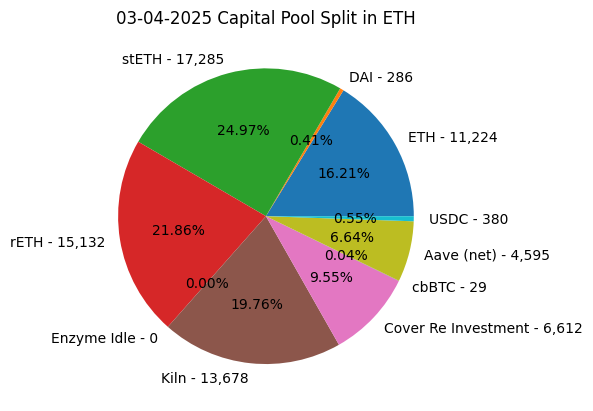

In [125]:
pie_asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme Idle', 'Kiln', 'Cover Re Investment', 'cbBTC', 'Aave (net)', 'USDC']
today_row_pie = today_row[pie_asset_list]

# add formatted ETH values to labels
labels = []
for n, i in enumerate(pie_asset_list):
    formatted_value = '{:,.0f}'.format(today_row_pie.values[n])
    labels.append(f'{i} - {formatted_value}')

# create chart
# extract latest date in string format
today_date_str = df_cap.iloc[0]['day'].strftime('%d-%m-%Y')
# create chart
plt.pie(today_row_pie.values, labels=labels, autopct='%1.2f%%')
plt.title(f'{today_date_str} Capital Pool Split in ETH');

## Monthly Averages Since Start of 2024 

In [126]:
# get today's day, month and year

day_today = datetime.now().day
month_today = datetime.now().month
year_today = datetime.now().year

# get eth price today
eth_usd_today = df_cap.iloc[0]['rate_ETH_USD']

# manually input average start date
averages_start_date_str = '01-08-2023'
# create average start datetime
averages_start_date = datetime.strptime(averages_start_date_str, '%d-%m-%Y')

In [127]:
# loop through months since the start date and obtain averages

date = averages_start_date
ramm_flows = []
net_eth_fees = []
claim_ratio = 0.7
stETH_returns = []
rETH_returns = []

while date < datetime(year_today, month_today, 1):
    next_month = datetime(year = date.year + int(date.month / 12), month = (date.month % 12) + 1, day=date.day)
    
    # RAMM FLOWS
    # determine net ramm flows in month in 2024
    if date.year >= 2024:
        ramm_flows_opening = df_ramm.loc[df_ramm['block_date'] == date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['block_date'] == date]['cummulative_eth_out'].values[0]
        ramm_flows_closing = df_ramm.loc[df_ramm['block_date'] == next_month]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['block_date'] == next_month]['cummulative_eth_out'].values[0]
        ramm_flows_change = ramm_flows_closing - ramm_flows_opening
        ramm_flows.append(ramm_flows_change)
    
    # COVERS
    # filter for covers that were bought in the relevant month
    df_cover_flows = df_covers[(df_covers['cover_start_time']>=date) & (df_covers['cover_start_time']<next_month)]

    # filter for covers that were paid for in ETH
    # (note covers paid in NXM don't generate assets and covers paid for in DAI/USDC will be used to pay off the Cover Re loan)
    df_cover_flows = df_cover_flows[df_cover_flows['premium_asset'] == 'ETH']

    # work out cover fees, allowing for 15% commission
    eth_cover_fees = df_cover_flows['premium_native'].sum() * 0.85
    # append to list, allowing for 70% claim ratio
    net_eth_monthly_fees = eth_cover_fees * (1 - claim_ratio)
    net_eth_fees.append(net_eth_monthly_fees)
    
    # INVESTMENT INCOME
    # stETH
    stETH_opening = df_cap.loc[df_cap['day'] == date]['stETH'].values[0]
    stETH_closing = df_cap.loc[df_cap['day'] == next_month]['stETH'].values[0]
    stETH_returns.append(stETH_closing - stETH_opening)
    # rETH
    rETH_opening = df_cap.loc[df_cap['day'] == date]['rETH'].values[0]
    rETH_closing = df_cap.loc[df_cap['day'] == next_month]['rETH'].values[0]
    rETH_returns.append(rETH_closing - rETH_opening) 
    
    # move date along
    date = next_month

# Average Kiln rewards in month
days_total_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_deposit_date)/timedelta(days=1)
daily_total_kiln_rewards = kiln_total_rewards / days_total_kiln_rewards
avg_monthly_kiln_returns = daily_total_kiln_rewards * avg_days_in_month

# Average RAMM flows
avg_monthly_ramm_flows = sum(ramm_flows)/len(ramm_flows)

# Average ETH Cover Fees
avg_monthly_net_eth_fees = sum(net_eth_fees)/len(net_eth_fees)

# Average stETH returns
avg_monthly_stETH_returns = sum(stETH_returns)/len(stETH_returns)

# Average rETH returns
avg_monthly_rETH_returns = sum(rETH_returns)/len(rETH_returns)

print(f'Average monthly stETH returns = {avg_monthly_stETH_returns}')
print(f'Average monthly rETH returns = {avg_monthly_rETH_returns}')
print(f'Average monthly kiln returns = {avg_monthly_kiln_returns}')
print(f'Average monthly net ETH cover fees = {avg_monthly_net_eth_fees}')
print(f'Average monthly RAMM flows = {avg_monthly_ramm_flows}')

Average monthly stETH returns = -768.1372340803404
Average monthly rETH returns = 35.879719848029254
Average monthly kiln returns = 19.47180774162371
Average monthly net ETH cover fees = 8.705600687179723
Average monthly RAMM flows = -2543.1471089537727


## Asset Projection

In [128]:
today_row

day                          2025-04-03 00:00:00
rate_ETH_USD                         1815.549259
ETH                                 11223.848363
DAI                                   285.512346
Enzyme                              13678.221318
stETH                               17284.929015
rETH                                15132.134956
USDC                                  380.378098
cbBTC                                  29.213227
Cover Re Investment                  6612.285119
Cover Re Loan Collateral             6486.585172
Cover Re Loan Outstanding            -1891.57634
sum                                 69221.531274
Aave (net)                           4595.008832
Kiln                                13678.221318
Enzyme Idle                                    0
Name: 0, dtype: object

In [129]:
proj_asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme Idle', 'Kiln', 'Cover Re Investment', 'Cover Re Loan Collateral',
                   'Cover Re Loan Outstanding', 'USDC']
today_row_proj = today_row[proj_asset_list]

asset_df = pd.DataFrame(today_row_proj).T

projection_months = 12
aave_eth_supply_apy = 0.0154
aave_usdc_borrow_apy = 0.0871
cover_re_apy = 0.2

for i in range(projection_months):
    
    next_row = {}
    next_row['ETH'] = asset_df['ETH'].values[-1] + avg_monthly_ramm_flows + avg_monthly_net_eth_fees
    next_row['DAI'] = asset_df['DAI'].values[-1]
    next_row['USDC'] = asset_df['USDC'].values[-1]
    next_row['stETH'] = asset_df['stETH'].values[-1] + avg_monthly_stETH_returns
    next_row['rETH'] = asset_df['rETH'].values[-1] + avg_monthly_rETH_returns
    next_row['Kiln'] = asset_df['Kiln'].values[-1] + avg_monthly_kiln_returns
    next_row['Enzyme Idle'] = asset_df['Enzyme Idle'].values[-1]
    next_row['Cover Re Investment'] = asset_df['Cover Re Investment'].values[-1] * ((1 + cover_re_apy)**(1/12))
    next_row['Cover Re Loan Collateral'] = asset_df['Cover Re Loan Collateral'].values[-1] * ((1 + aave_eth_supply_apy)**(1/12))
    next_row['Cover Re Loan Outstanding'] = asset_df['Cover Re Loan Outstanding'].values[-1] * ((1 + aave_usdc_borrow_apy)**(1/12))
    
    asset_df.loc[len(asset_df)] = next_row

asset_df

,ETH,DAI,stETH,rETH,Enzyme Idle,Kiln,Cover Re Investment,Cover Re Loan Collateral,Cover Re Loan Outstanding,USDC
0,11223.848363,285.512346,17284.929015,15132.134956,0,13678.221318,6612.285119,6486.585172,-1891.57634,380.378098
1,8689.406855,285.512346,16516.791781,15168.014676,0,13697.693126,6713.515703,6494.851438,-1904.786617,380.378098
2,6154.965347,285.512346,15748.654546,15203.894396,0,13717.164933,6816.296074,6503.128238,-1918.089152,380.378098
3,3620.523838,285.512346,14980.517312,15239.774116,0,13736.636741,6920.649957,6511.415586,-1931.484588,380.378098
4,1086.08233,285.512346,14212.380078,15275.653835,0,13756.108549,7026.601444,6519.713495,-1944.973574,380.378098
5,-1448.359178,285.512346,13444.242844,15311.533555,0,13775.580356,7134.174991,6528.021978,-1958.556764,380.378098
6,-3982.800686,285.512346,12676.10561,15347.413275,0,13795.052164,7243.395433,6536.34105,-1972.234815,380.378098
7,-6517.242195,285.512346,11907.968376,15383.292995,0,13814.523972,7354.287981,6544.670723,-1986.008391,380.378098
8,-9051.683703,285.512346,11139.831142,15419.172715,0,13833.99578,7466.878236,6553.011011,-1999.878157,380.378098
9,-11586.125211,285.512346,10371.693908,15455.052435,0,13853.467587,7581.192188,6561.361927,-2013.844786,380.378098


In [130]:
asset_df_6_mo = asset_df[:6].astype(float)
asset_df_6_mo_pos = asset_df_6_mo.drop(columns=['Cover Re Loan Outstanding'])

[Text(0, -5000.0, '-5,000'),
 Text(0, -2500.0, '-2,500'),
 Text(0, 0.0, '0'),
 Text(0, 2500.0, '2,500'),
 Text(0, 5000.0, '5,000'),
 Text(0, 7500.0, '7,500'),
 Text(0, 10000.0, '10,000'),
 Text(0, 12500.0, '12,500'),
 Text(0, 15000.0, '15,000'),
 Text(0, 17500.0, '17,500'),
 Text(0, 20000.0, '20,000')]

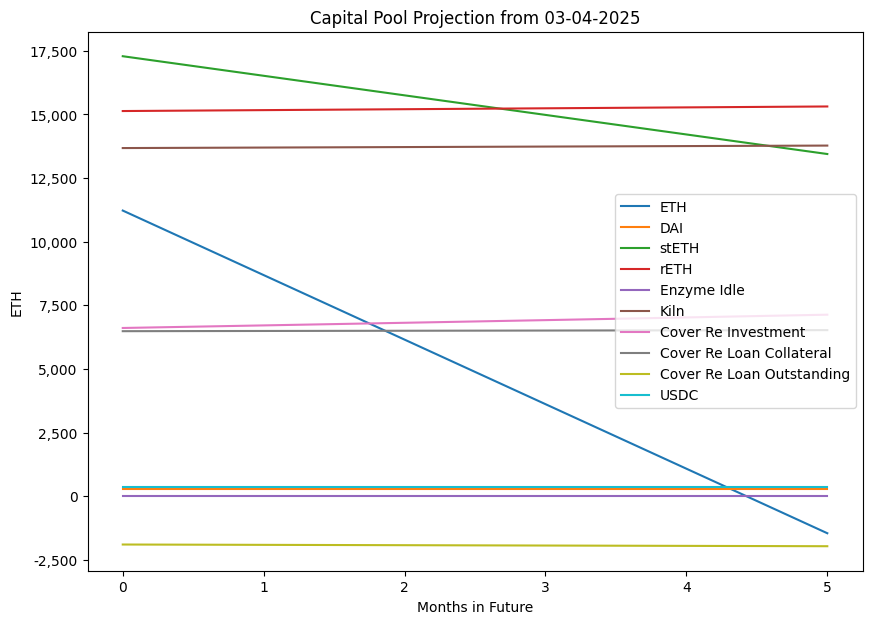

In [131]:
# Plot the data
projection_plot = asset_df_6_mo.plot(
    title=f'Capital Pool Projection from {today_date_str}',
    figsize=(10, 7),
    legend=True,
    ylabel='ETH',
    xlabel='Months in Future'
)

# Get the tick values and format them
tick_vals = projection_plot.get_yticks()
projection_plot.yaxis.set_major_locator(FixedLocator(tick_vals))
projection_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])

[Text(0, -10000.0, '-10,000'),
 Text(0, 0.0, '0'),
 Text(0, 10000.0, '10,000'),
 Text(0, 20000.0, '20,000'),
 Text(0, 30000.0, '30,000'),
 Text(0, 40000.0, '40,000'),
 Text(0, 50000.0, '50,000'),
 Text(0, 60000.0, '60,000'),
 Text(0, 70000.0, '70,000'),
 Text(0, 80000.0, '80,000')]

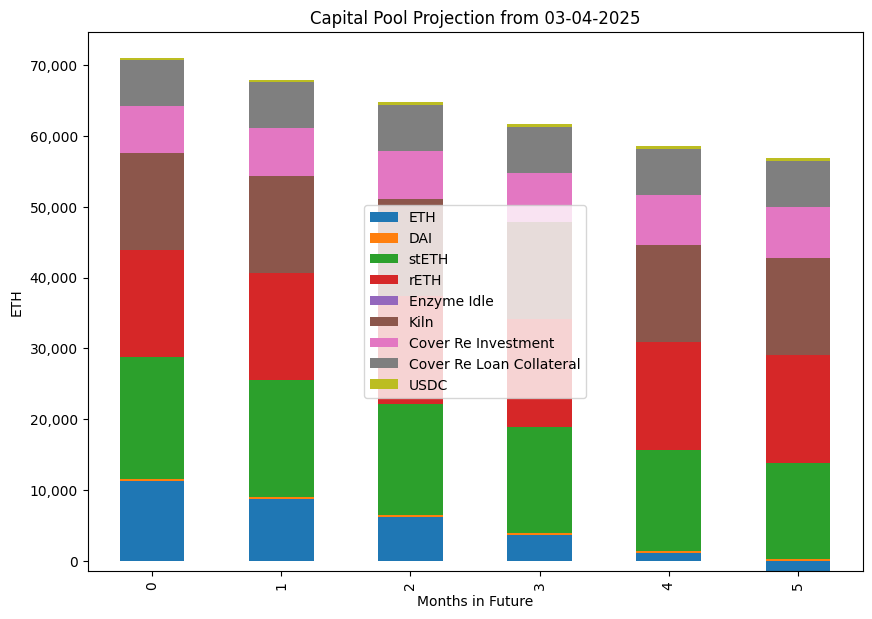

In [132]:
# Plot the data
projection_bar_plot = asset_df_6_mo_pos.plot(
    kind='bar', 
    stacked=True, 
    title=f'Capital Pool Projection from {today_date_str}',
    figsize=(10, 7), 
    legend=True, 
    ylabel='ETH', 
    xlabel='Months in Future'
)

# Fix y-ticks for the bar plot
tick_vals = projection_bar_plot.get_yticks()
projection_bar_plot.yaxis.set_major_locator(FixedLocator(tick_vals))
projection_bar_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])

In [133]:
df_sum = asset_df_6_mo_pos.sum(axis=1)
df_rel = asset_df_6_mo_pos.div(df_sum, 0)*100
df_rel

,ETH,DAI,stETH,rETH,Enzyme Idle,Kiln,Cover Re Investment,Cover Re Loan Collateral,USDC
0,15.789580,0.401655,24.316238,21.287712,0.0,19.242363,9.302086,9.125253,0.535112
1,12.788664,0.420204,24.308645,22.323578,0.0,20.159627,9.880640,9.558820,0.559823
2,9.496939,0.440538,24.299732,23.459182,0.0,21.165200,10.517353,10.034144,0.586913
3,5.870288,0.462927,24.289288,24.709645,0.0,22.272470,11.221085,10.557556,0.616742
4,1.855205,0.487702,24.277059,26.093303,0.0,23.497673,12.002579,11.136732,0.649748
5,-2.613844,0.515262,24.262732,27.632618,0.0,24.860694,12.874996,11.781076,0.686466


In [134]:
for n in df_rel: 
    for i, (cs, ab, pc) in enumerate(zip(asset_df_6_mo_pos.cumsum(1)[n],  
                                         asset_df_6_mo_pos[n], df_rel[n])): 
        print(cs - ab / 2, i, str(np.round(pc, 1)) + '%')

5611.924181595485 0 15.8%
4344.703427462187 1 12.8%
3077.482673328891 2 9.5%
1810.2619191955946 3 5.9%
543.0411650622981 4 1.9%
-724.1795890709984 5 -2.6%
11366.604536338877 0 0.4%
8832.163028072282 1 0.4%
6297.721519805688 2 0.4%
3763.280011539096 3 0.5%
1228.8385032725032 4 0.5%
-1305.60300499409 5 0.5%
20151.825216808105 0 24.3%
17233.31509150134 1 24.3%
14314.804966194577 2 24.3%
11396.294840887815 3 24.3%
8477.784715581052 4 24.3%
5559.274590274286 5 24.3%
36360.35720216089 0 21.3%
33075.71831973798 1 22.3%
29791.07943731506 2 23.5%
26506.440554892142 3 24.7%
23221.80167246922 4 26.1%
19937.1627900463 5 27.6%
43926.424680192365 0 0.0%
40659.72565769346 1 0.0%
37393.02663519456 2 0.0%
34126.327612695655 3 0.0%
30859.62859019675 4 0.0%
27592.929567697844 5 0.0%
50765.53533907668 0 19.2%
47508.572220448594 1 20.2%
44251.609101820504 2 21.2%
40994.64598319241 3 22.3%
37737.68286456431 4 23.5%
34480.71974593622 5 24.9%
60910.78855742844 0 9.3%
57714.17663465323 1 9.9%
54518.33960519746

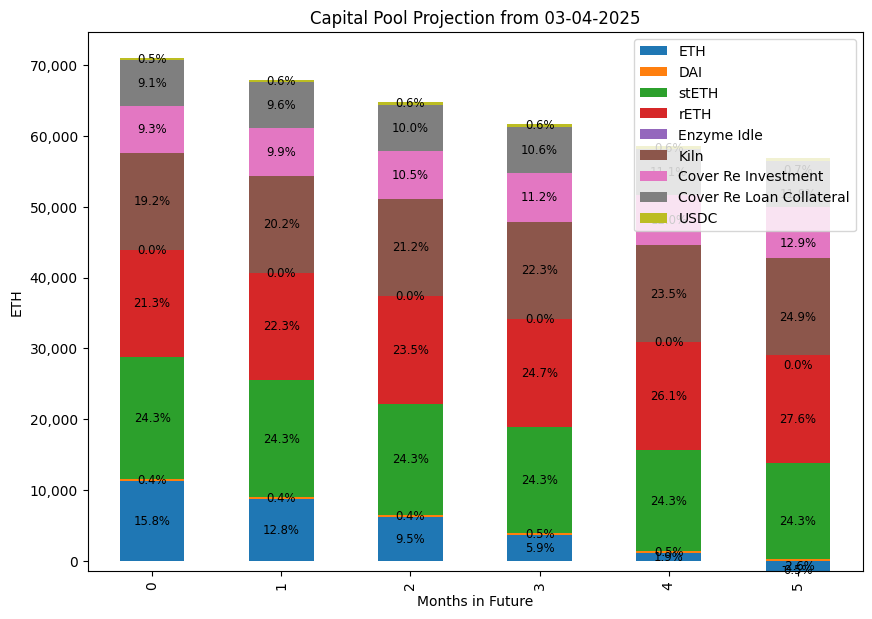

In [135]:
# Plot the data
projection_bar_perc_plot = asset_df_6_mo_pos.plot(
    kind='bar', 
    stacked=True, 
    title=f'Capital Pool Projection from {today_date_str}',
    figsize=(10, 7), 
    legend=True, 
    ylabel='ETH', 
    xlabel='Months in Future'
)

# Fix y-ticks for the bar plot
tick_vals = projection_bar_perc_plot.get_yticks()
projection_bar_perc_plot.yaxis.set_major_locator(FixedLocator(tick_vals))
projection_bar_perc_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])

# Add percentage labels
for n in df_rel: 
    for i, (cs, ab, pc) in enumerate(zip(asset_df_6_mo_pos.cumsum(1)[n],  
                                         asset_df_6_mo_pos[n], df_rel[n])): 
        projection_bar_perc_plot.text(
            y=cs - ab / 2, 
            x=i, 
            s=f'{np.round(pc, 1)}%', 
            va='center', 
            ha='center', 
            size='small'
        )

# Newsletter output

In [137]:
print('State of the Capital Pool')
print()

print(f'Capital Pool Percentage Change (ETH) = {round(100 * capital_pool_change / (df_waterfall.loc["opening capital pool"].values[0]), 2)}%')
print(f'Opening Capital Pool (ETH) = {total_cap_monthly_opening:,.2f}')
print(f'Closing Capital Pool (ETH) = {total_eth:,.2f}')
print()

print(f'Capital Pool Percentage Change (BV per NXM) = {round(100 * capital_pool_change_nxm / (df_waterfall_nxm.loc["opening capital pool"].values[0]), 2)}%')
print(f'Opening Book Value per NXM = {total_cap_monthly_opening / nxm_supply_monthly_opening:,.6f}')
print(f'Closing Book Value per NXM = {total_nxm / factor:,.6f}')
print()

print(f'Aave USDC repayment, date: {repayment_date_str}, amount = {debtUSDC_monthly_repayment:,.2f}') # in ETH (USDC needed): opening = {debtUSDC_monthly_opening}, closing = {debtUSDC_monthly_closing:}
print(f'stETH Divestment, date: {stETH_sale_date_str}, amount = {stETH_sale_amount:,.2f}')


State of the Capital Pool

Capital Pool Percentage Change (ETH) = -2.65%
Opening Capital Pool (ETH) = 71,442.86
Closing Capital Pool (ETH) = 69,551.46

Capital Pool Percentage Change (BV per NXM) = 1.95%
Opening Book Value per NXM = 0.023822
Closing Book Value per NXM = 0.024286

Aave USDC repayment, date: 12-03-2025, amount = 419,232.95
stETH Divestment, date: 31-03-2025, amount = 1,601.15
